In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import xarray as xr
from itertools import product
import pandas as pd

from polarization_controller import polarization_bidi

from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")
plt.style.use("plot_style.mplstyle")

In [2]:
## Source for connector return loss is taken from DR4 MSA document like: https://static.s123-cdn-static-d.com/uploads/2598123/normal_60bf88b173c87.pdf

connector_return_loss_values = [-30, -35, -40, -45, -50]
num_dc_sweep = 10001
num_fiber_rotation_sweep = num_dc_sweep
sample_points = num_fiber_rotation_sweep * 7

Text(0.5, 1.0, '125 SM MMC Elite Connector')

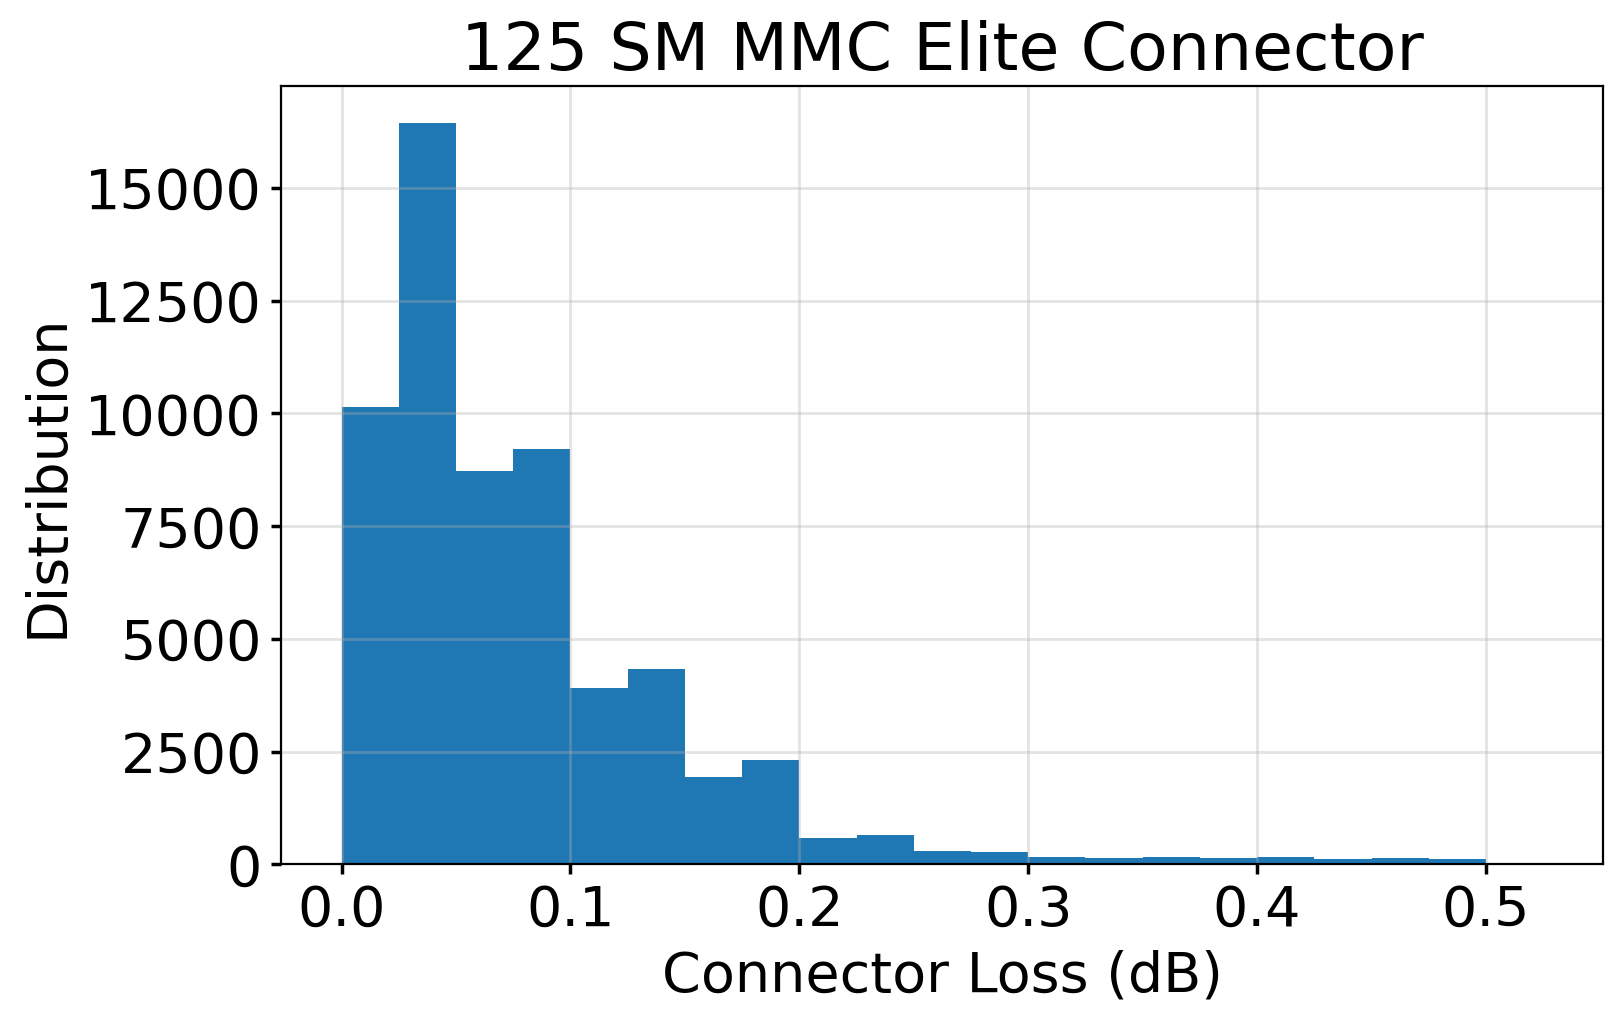

In [3]:
############ELITE 125-125#########
#create a histogram of 125elite-125elite using values from the pdf
file_path3 = '12SM_MT_Elite.xlsx'  
df = pd.read_excel(file_path3)
# print(df.keys())
column_name = 'x' 
bin_edges = df[column_name].to_numpy()
column_name = 'y' 
hist_values = df[column_name].to_numpy()
hist_values = hist_values[:-1]

# Normalize the histogram to create a PDF
bin_widths = np.diff(bin_edges)
pdf = hist_values / (np.sum(hist_values) * bin_widths)
# Create the cumulative distribution function (CDF)
cdf = np.cumsum(pdf * bin_widths)
# Generate random samples from the PDF (CDF method)
num_samples = num_fiber_rotation_sweep * 6  # Adjust as needed
elite125_values = np.interp(np.random.rand(num_samples), cdf, bin_edges[:-1])

average_conncetor_loss = np.median(elite125_values)

plt.hist(elite125_values, bins=bin_edges)
plt.xlabel("Connector Loss (dB)")
plt.ylabel("Distribution")
plt.title("125 SM MMC Elite Connector")


Text(0, 0.5, 'Distribution')

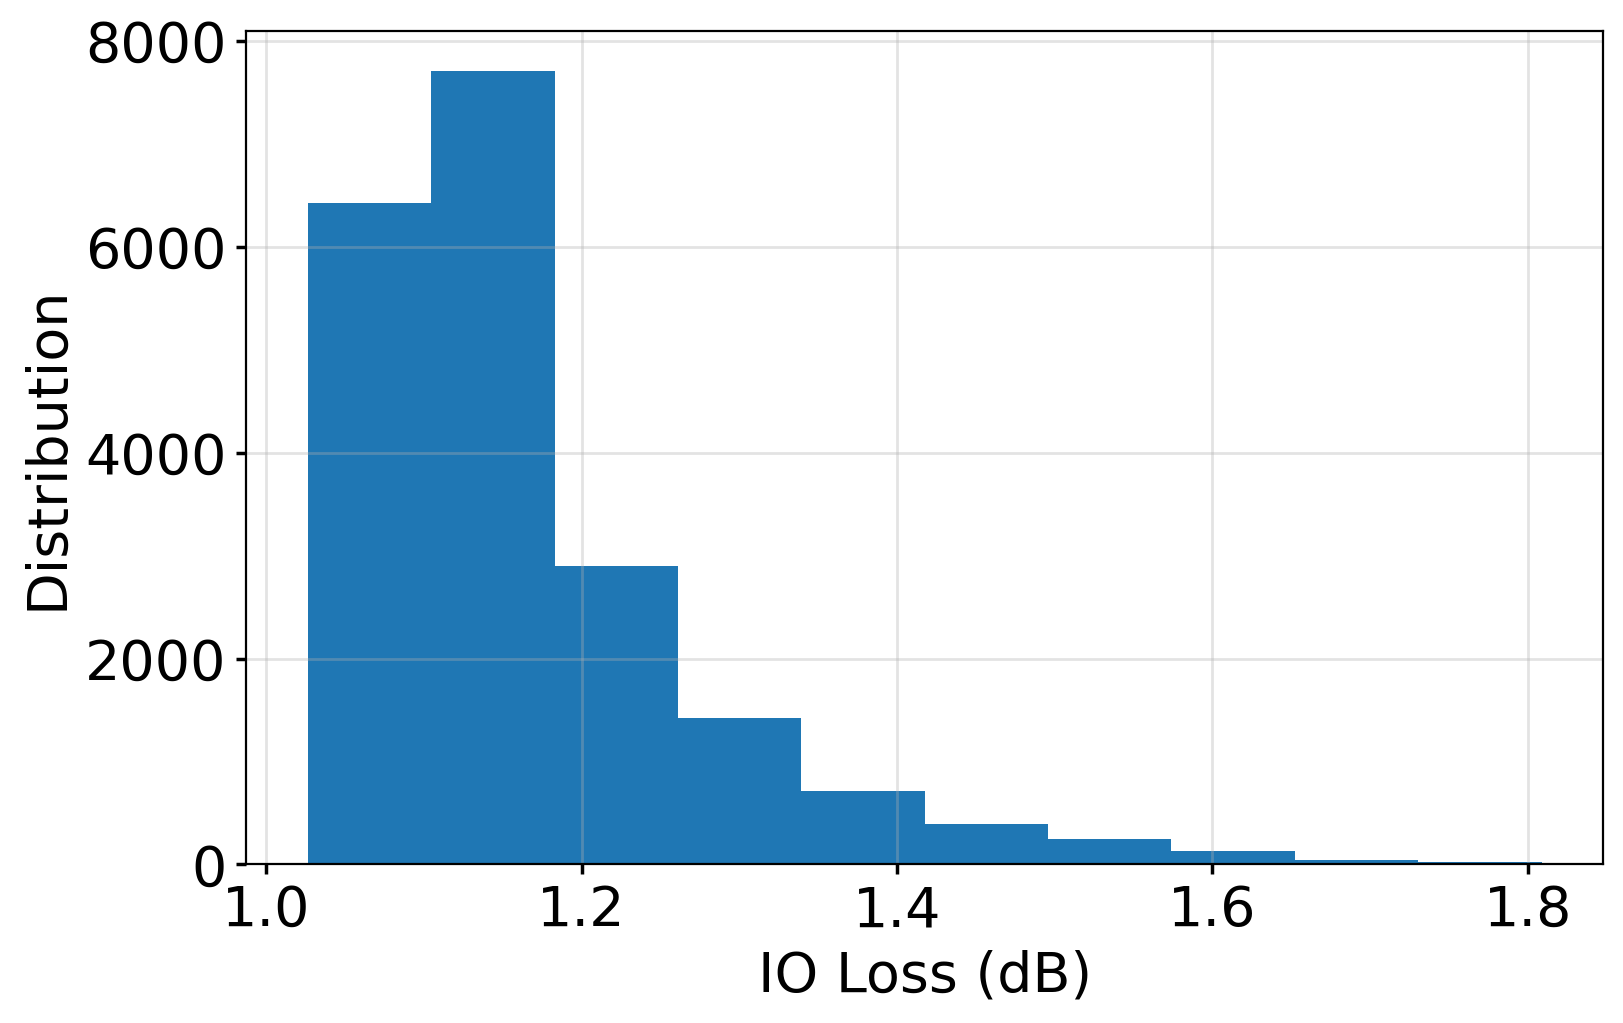

In [4]:
######## CONNECTOR ############
## Psaila, Nicholas, et al. "Detachable Optical Chiplet Connector for Co-Packaged Photonics." Journal of Lightwave Technology (2023).
file_path4 = 'Connector.xlsx'
df = pd.read_excel(file_path4)

column_name = 'x' 
bin_edges = df[column_name].to_numpy()
column_name = 'y' 
hist_values = df[column_name].to_numpy()
hist_values = hist_values[:-1]

# Normalize the histogram to create a PDF
bin_widths = np.diff(bin_edges)
pdf = hist_values / (np.sum(hist_values) * bin_widths)
# Create the cumulative distribution function (CDF)
cdf = np.cumsum(pdf * bin_widths)
# Generate random samples from the PDF (CDF method)
num_samples = num_fiber_rotation_sweep * 2  # Adjust as needed
total_values = np.interp(np.random.rand(num_samples), cdf, bin_edges[:-1])

intel_connector_values = (total_values-3 )/2

average_conncetor_loss = np.median(intel_connector_values)

plt.hist(intel_connector_values)
plt.xlabel("IO Loss (dB)")
plt.ylabel("Distribution")

In [5]:
p_bidi = polarization_bidi()

voltages = np.linspace(0, 3, sample_points)
phase_shifts = np.linspace(0, 2*np.pi, sample_points)

rotation_rx = phase_shifts[np.random.permutation(sample_points)]
rotation_ry = phase_shifts[np.random.permutation(sample_points)]
rotation_rz = phase_shifts[np.random.permutation(sample_points)]
rotation_delta = phase_shifts[np.random.permutation(sample_points)]

p_bidi.fiber_1._rotation = (rotation_rx[0], rotation_ry[0], rotation_rz[0], rotation_delta[0])
p_bidi.fiber_2._rotation = (rotation_rx[1], rotation_ry[1], rotation_rz[1], rotation_delta[1])
p_bidi.fiber_3._rotation = (rotation_rx[2], rotation_ry[2], rotation_rz[2], rotation_delta[2])
p_bidi.fiber_4._rotation = (rotation_rx[3], rotation_ry[3], rotation_rz[3], rotation_delta[3])
p_bidi.fiber_5._rotation = (rotation_rx[4], rotation_ry[4], rotation_rz[4], rotation_delta[4])
p_bidi.fiber_6._rotation = (rotation_rx[5], rotation_ry[5], rotation_rz[5], rotation_delta[5])
p_bidi.fiber_7._rotation = (rotation_rx[6], rotation_ry[6], rotation_rz[6], rotation_delta[6])

p_bidi.recursive_update()

In [6]:
def objective_function_df(voltages, input_state, params):
  """
  Objective function for the optimization.
  Args:
      bidi: Bidi class representing the optical link.
      voltages: Voltages applied to the phase shifters.
      input_state: Input state of the device.
      params: Dictionary of parameters for the optimization.
  Returns:
      The cost function.
  """
  p_bidi.bidi_tx.pa.XPS1.heater_voltage = voltages[0]
  p_bidi.bidi_tx.pa.XPS2.heater_voltage = voltages[1]
  p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = voltages[2]
  p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = voltages[3]

  if len(voltages) > 4:
    p_bidi.bidi_tx.mzi_2.XPS1.heater_voltage = voltages[4]
    p_bidi.bidi_tx.mzi_2.XPS2.heater_voltage = voltages[5]

  p_bidi.recursive_update()

  output_state = p_bidi.smatrix @ input_state
  
  I_back_top_port = np.abs(output_state[0])**2
  I_back_bottom_port = np.abs(output_state[1])**2
  I_top_port = np.abs(output_state[2])**2
  I_bottom_port = np.abs(output_state[3])**2

  intensities = [I_back_top_port, I_back_bottom_port, I_top_port, I_bottom_port]

  curr_params = []
  for volts in voltages:
    curr_params.append(volts)
  for state in output_state:
    curr_params.append(np.abs(state)**2)
  for inten in intensities:
    curr_params.append(inten)
  params.append(curr_params)

  return -1 * I_bottom_port

def plot_optimization(params):
  iters = np.arange(len(params))
  params = np.array(params)
  labels = ['PA-1:XPS1', 'PA-1:XPS2', 'MZI-1:XPS1', 'MZI-1: XPS2', 'MZI-2:XPS1', 'MZI-2: XPS2']
  plt.figure(figsize=(7.5, 8), dpi=400)
  plt.subplot(2, 1, 1)
  if len(params[0,:]) > 12:
    plt.plot(iters, params[:, 0:6], label=labels)
  else:
    plt.plot(iters, params[:, 0:4], label=labels[0:4])

  plt.ylabel('Voltage [V]')
  plt.xlabel('Iteration number')
  plt.legend(fontsize=12)
  plt.grid(True, which="both", ls="dashed", color='.9')

  labels = [
      "Reflected Top port",
      "Reflected Bottom port",
      "Transmitted Top port",
      "Transmitted Bottom port"
  ]
  plt.subplot(2, 1, 2)
  if len(params[0,:]) > 12:
    plt.plot(iters, params[:, 12:], label=labels)
  else:
    plt.plot(iters, params[:, 8:], label=labels)

  plt.ylabel('transmission')
  plt.xlabel('Iteration number')
  plt.ylim([0, 0.1])
  plt.legend(fontsize=10)
  plt.grid(True, which="both", ls="dashed", color='.9')

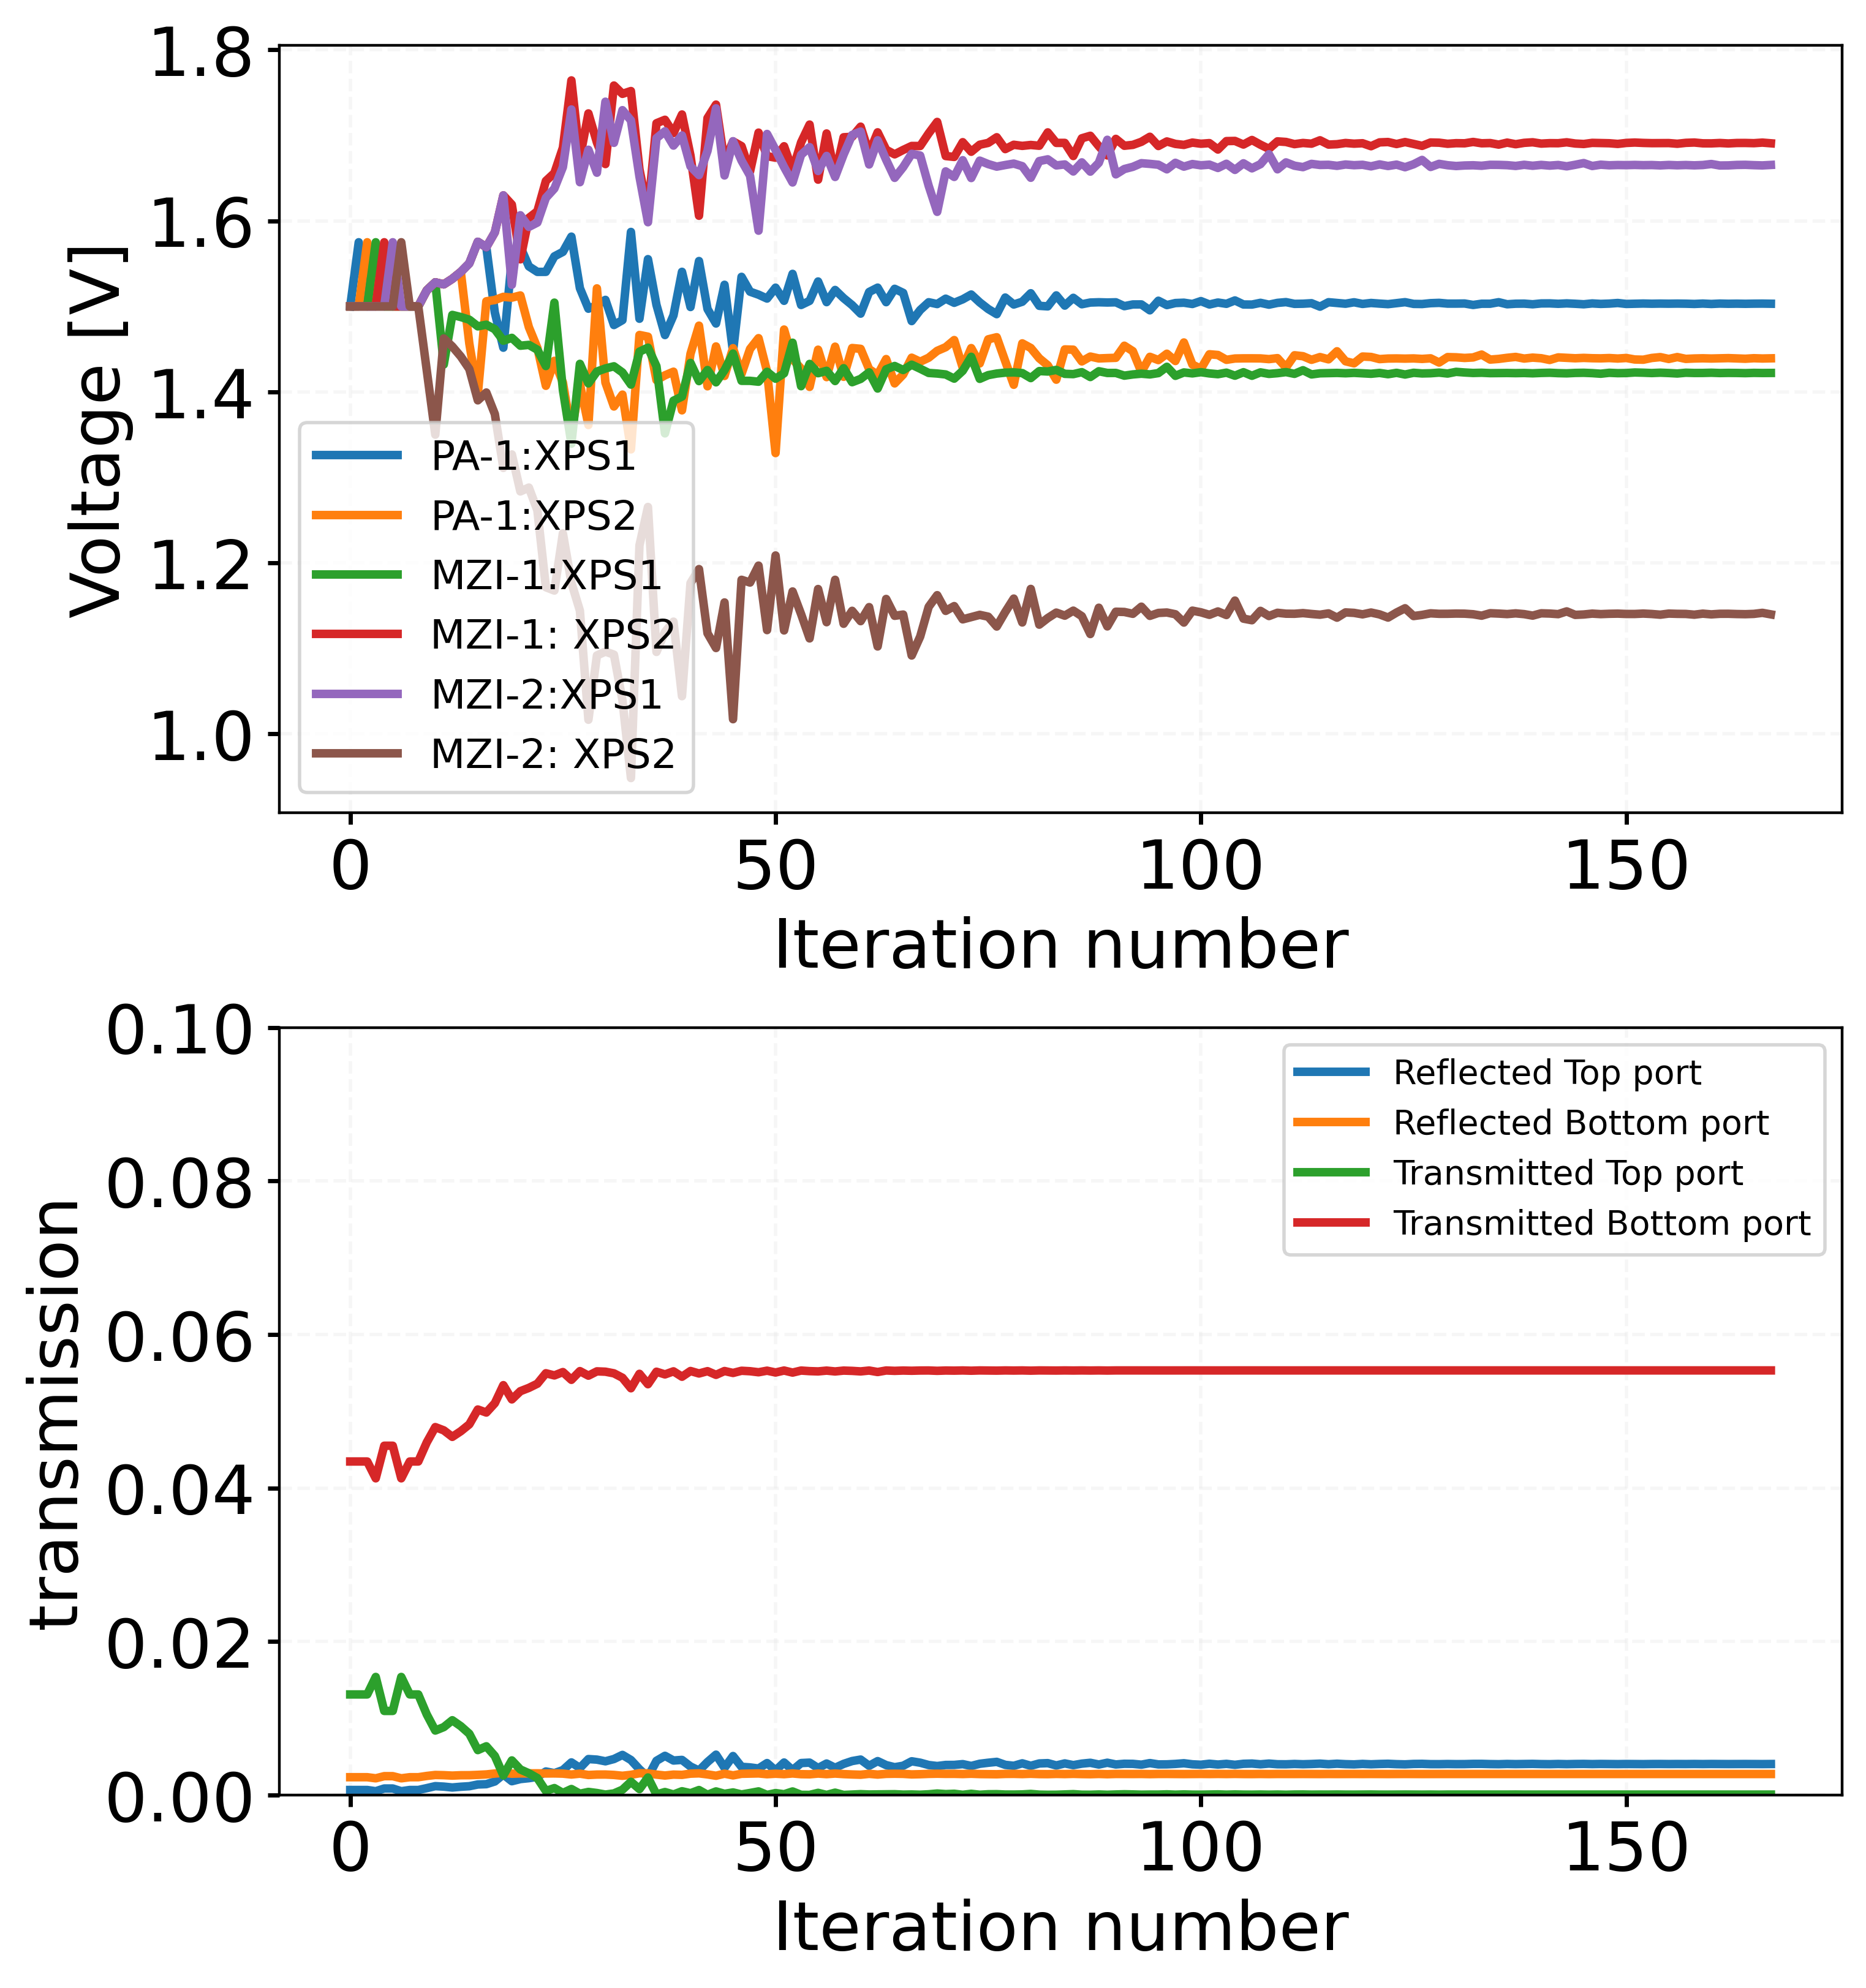

In [7]:
bounds = [(0, 3), (0, 3), (0, 3), (0, 3), (0,3), (0,3), (0,3), (0,3)]
input_state = np.array([1, 0, 0, 0])

opts = {
  "maxiter": 1000,
  'xatol': 1e-3,
  'fatol': 1e-3,
}

params = []

result = minimize(
  objective_function_df,
  ((1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5)),
  bounds=bounds,
  args=(input_state, params),
  method='Nelder-Mead',
  options=opts
  )

plot_optimization(params)

In [8]:
input_state = np.array([1, 0, 0, 0])
output_state = p_bidi.smatrix @ input_state
print("Output state direction: ", np.abs(output_state)**2)

input_state_reverse = np.array([0, 0, 1, 0])
output_state_reverse = p_bidi.smatrix @ input_state_reverse
print("Output state reverse direction: ", np.abs(output_state_reverse)**2)

optimized_params = params[-1]

Output state direction:  [4.03861963e-03 2.73551755e-03 5.75563068e-05 5.53262831e-02]
Output state reverse direction:  [5.75563068e-05 5.63651885e-02 1.45183349e-03 3.11564835e-03]


In [9]:
random_variable_sigma = [0.02, 0.05, 0.1]

random_dc1 = {}
random_dc2 = {}

for sigma in random_variable_sigma:
  random_dc1[sigma] = (1 + np.random.normal(0, sigma, num_dc_sweep))*0.5
  random_dc2[sigma] = (1 + np.random.normal(0, sigma, num_dc_sweep))*0.5

In [10]:
random_alpha = {}
random_connector_loss = {}
random_connector_return_loss = {}
random_io_loss = {}
index = 0
for idd_conn, connector_loss in enumerate(connector_return_loss_values):
  for idd in range(num_fiber_rotation_sweep):
    random_alpha[index] = {
      "fiber_1": (rotation_rx[idd*7+0], rotation_ry[idd*7+0], rotation_rz[idd*7+0], rotation_delta[idd*7+0]),
      "fiber_2": (rotation_rx[idd*7+1], rotation_ry[idd*7+1], rotation_rz[idd*7+1], rotation_delta[idd*7+1]),
      "fiber_3": (rotation_rx[idd*7+2], rotation_ry[idd*7+2], rotation_rz[idd*7+2], rotation_delta[idd*7+2]),
      "fiber_4": (rotation_rx[idd*7+3], rotation_ry[idd*7+3], rotation_rz[idd*7+3], rotation_delta[idd*7+3]),
      "fiber_5": (rotation_rx[idd*7+4], rotation_ry[idd*7+4], rotation_rz[idd*7+4], rotation_delta[idd*7+4]),
      "fiber_6": (rotation_rx[idd*7+5], rotation_ry[idd*7+5], rotation_rz[idd*7+5], rotation_delta[idd*7+5]),
      "fiber_7": (rotation_rx[idd*7+6], rotation_ry[idd*7+6], rotation_rz[idd*7+6], rotation_delta[idd*7+6]),
    }
    random_connector_loss[index] = {
      "connector_1": elite125_values[idd*6+0],
      "connector_2": elite125_values[idd*6+1],
      "connector_3": elite125_values[idd*6+2],
      "connector_4": elite125_values[idd*6+3],
      "connector_5": elite125_values[idd*6+4],
      "connector_6": elite125_values[idd*6+5],
    }
    random_connector_return_loss[index] = {
      "connector_1": connector_loss,
      "connector_2": connector_loss,
      "connector_3": connector_loss,
      "connector_4": connector_loss,
      "connector_5": connector_loss,
      "connector_6": connector_loss,
    }
    random_io_loss[index] = {
      "ec_1": intel_connector_values[idd*2+0],
      "ec_2": intel_connector_values[idd*2+1],
    }

    index += 1

In [11]:
polarization_controller_fiber_variability_mode = {}

idd_dataset = 1

for idd in tqdm(range(index)):
  p_bidi.fiber_1._rotation = random_alpha[idd]["fiber_1"]
  p_bidi.fiber_2._rotation = random_alpha[idd]["fiber_2"]
  p_bidi.fiber_3._rotation = random_alpha[idd]["fiber_3"]
  p_bidi.fiber_4._rotation = random_alpha[idd]["fiber_4"]
  p_bidi.fiber_5._rotation = random_alpha[idd]["fiber_5"]
  p_bidi.fiber_6._rotation = random_alpha[idd]["fiber_6"]
  p_bidi.fiber_7._rotation = random_alpha[idd]["fiber_7"]

  p_bidi.oc_1._loss = random_connector_loss[idd]["connector_1"]
  p_bidi.oc_2._loss = random_connector_loss[idd]["connector_2"]
  p_bidi.oc_3._loss = random_connector_loss[idd]["connector_3"]
  p_bidi.oc_4._loss = random_connector_loss[idd]["connector_4"]
  p_bidi.oc_5._loss = random_connector_loss[idd]["connector_5"]
  p_bidi.oc_6._loss = random_connector_loss[idd]["connector_6"]

  p_bidi.oc_1._return_loss = random_connector_return_loss[idd]["connector_1"]
  p_bidi.oc_2._return_loss = random_connector_return_loss[idd]["connector_2"]
  p_bidi.oc_3._return_loss = random_connector_return_loss[idd]["connector_3"]
  p_bidi.oc_4._return_loss = random_connector_return_loss[idd]["connector_4"]
  p_bidi.oc_5._return_loss = random_connector_return_loss[idd]["connector_5"]
  p_bidi.oc_6._return_loss = random_connector_return_loss[idd]["connector_6"]

  p_bidi.bidi_tx.edge_coupler._te_loss = random_io_loss[idd]["ec_1"]
  p_bidi.bidi_tx.edge_coupler._tm_loss = random_io_loss[idd]["ec_1"]
  p_bidi.bidi_rx.edge_coupler._te_loss = random_io_loss[idd]["ec_2"]
  p_bidi.bidi_rx.edge_coupler._tm_loss = random_io_loss[idd]["ec_2"]

  p_bidi.bidi_tx.mzi_1.dc1._splitratio = 0.5
  p_bidi.bidi_tx.mzi_1.dc2._splitratio = 0.5

  p_bidi.recursive_update()

  bounds = [(0, 3), (0, 3), (0, 3), (0, 3)]
  input_state = np.array([1, 0, 0, 0])

  opts = {
    "maxiter": 1000,
    'xatol': 1e-3,
    'fatol': 1e-3,
  }

  params = []

  result = minimize(
    objective_function_df,
    ((1.5, 1.5, 1.5, 1.5)),
    bounds=bounds,
    args=(input_state, params),
    method='Nelder-Mead',
    options=opts
    )

  input_state = np.array([1, 0, 0, 0])
  output_state = p_bidi.smatrix @ input_state

  input_state_reverse = np.array([0, 0, 1, 0])
  output_state_reverse = p_bidi.smatrix @ input_state_reverse

  polarization_controller_fiber_variability_mode[idd_dataset] = {
    "simulation_mode": "monte_carlo",
    "dc_sigma": 0,
    "dc1": 0.5,
    "dc2": 0.5,
    "input_state": input_state,
    "input_state_reverse": input_state_reverse,
    "output_state_forward_intensity": np.abs(output_state)**2,
    "output_state_forward": output_state,
    "output_state_reverse_intensity": np.abs(output_state_reverse)**2,
    "output_state_reverse":output_state_reverse,
    "heater_params": params[-1][0:4],
    "fiber_rotation": random_alpha[idd],
    "connector_loss": random_connector_loss[idd],
    "connector_return_loss": random_connector_return_loss[idd],
    "io_loss": random_io_loss[idd],
  }
  idd_dataset += 1

100%|██████████| 50005/50005 [1:08:26<00:00, 12.18it/s]


In [12]:
simulation_mode = ["monte_carlo"]
fiber_settings = np.zeros((len(simulation_mode), num_fiber_rotation_sweep, len(connector_return_loss_values)))
input_state = np.zeros((len(simulation_mode), num_fiber_rotation_sweep, len(connector_return_loss_values), 4))
input_state_reverse = np.zeros((len(simulation_mode), num_fiber_rotation_sweep, len(connector_return_loss_values), 4))
output_state_forward_intensity = np.zeros((len(simulation_mode), num_fiber_rotation_sweep,len(connector_return_loss_values), 4))
output_state_forward = np.zeros((len(simulation_mode), num_fiber_rotation_sweep, len(connector_return_loss_values),4), dtype=np.complex_)
output_state_reverse_intensity = np.zeros((len(simulation_mode), num_fiber_rotation_sweep, len(connector_return_loss_values),4))
output_state_reverse = np.zeros((len(simulation_mode), num_fiber_rotation_sweep, len(connector_return_loss_values),4), dtype=np.complex_)
heater_params = np.zeros((len(simulation_mode), num_fiber_rotation_sweep, len(connector_return_loss_values),4))
dc1 = np.zeros((len(simulation_mode), num_fiber_rotation_sweep,len(connector_return_loss_values)))
dc2 = np.zeros((len(simulation_mode), num_fiber_rotation_sweep,len(connector_return_loss_values)))
dc_sigma = np.zeros((len(simulation_mode), num_fiber_rotation_sweep,len(connector_return_loss_values)))
fiber_rotation = np.zeros((len(simulation_mode), num_fiber_rotation_sweep, len(connector_return_loss_values), 7, 4))
connector_loss = np.zeros((len(simulation_mode), num_fiber_rotation_sweep,len(connector_return_loss_values), 6))
io_loss = np.zeros((len(simulation_mode), num_fiber_rotation_sweep,len(connector_return_loss_values), 2))

for idd_return_loss in range(len(connector_return_loss_values)):
  for idd_fiber in range(num_fiber_rotation_sweep):
    for idd_mode, mode in enumerate(simulation_mode):
      dataset = polarization_controller_fiber_variability_mode[idd_return_loss * num_fiber_rotation_sweep + idd_fiber+1]
      input_state[idd_mode, idd_fiber, idd_return_loss, :] = dataset["input_state"]
      input_state_reverse[idd_mode, idd_fiber,idd_return_loss, :] = dataset["input_state_reverse"]
      output_state_forward_intensity[idd_mode, idd_fiber, idd_return_loss,:] = dataset["output_state_forward_intensity"]
      output_state_forward[idd_mode, idd_fiber,idd_return_loss, :] = dataset["output_state_forward"]
      output_state_reverse_intensity[idd_mode, idd_fiber,idd_return_loss, :] = dataset["output_state_reverse_intensity"]
      output_state_reverse[idd_mode, idd_fiber, idd_return_loss,:] = dataset["output_state_reverse"]
      heater_params[idd_mode, idd_fiber,idd_return_loss, :] = dataset["heater_params"]
      dc1[idd_mode, idd_fiber, idd_return_loss,] = dataset["dc1"]
      dc2[idd_mode, idd_fiber,idd_return_loss,] = dataset["dc2"]
      dc_sigma[idd_mode, idd_fiber,idd_return_loss,] = dataset["dc_sigma"]
      fiber_rotation[idd_mode, idd_fiber, idd_return_loss,:, :] = np.array(list(dataset["fiber_rotation"].values()))
      connector_loss[idd_mode, idd_fiber, idd_return_loss,:] = np.array(list(dataset["connector_loss"].values()))
      io_loss[idd_mode, idd_fiber, idd_return_loss,:] = np.array(list(dataset["io_loss"].values()))

In [13]:
polarization_bidi_dataset = xr.Dataset(
  data_vars=dict(
    input_state=(["simulation_mode", "sweep_idd", "connector_return_loss", "port"], input_state),
    input_state_reverse=(["simulation_mode", "sweep_idd","connector_return_loss",  "port"], input_state_reverse),
    output_state_forward_intensity=(["simulation_mode", "sweep_idd", "connector_return_loss", "port"], output_state_forward_intensity),
    output_state_reverse_intensity=(["simulation_mode", "sweep_idd", "connector_return_loss", "port"], output_state_reverse_intensity),
    heater_params=(["simulation_mode", "sweep_idd","connector_return_loss",  "heaters"], heater_params),
    dc1=(["simulation_mode", "sweep_idd","connector_return_loss"], dc1),
    dc2=(["simulation_mode", "sweep_idd", "connector_return_loss"], dc2),
    dc_sigma=(["simulation_mode", "sweep_idd", "connector_return_loss"], dc_sigma),
    fiber_rotation=(["simulation_mode", "sweep_idd", "connector_return_loss", "fiber_num", "axis"], fiber_rotation),
    connector_loss=(["simulation_mode", "sweep_idd", "connector_return_loss", "connector_num"], connector_loss),
    io_loss=(["simulation_mode", "sweep_idd", "connector_return_loss", "chip"], io_loss),
  ),
  coords=dict(
    simulation_mode=simulation_mode,
    sweep_idd=np.arange(num_fiber_rotation_sweep),
    port=["reverse_top", "reverse_bottom", "forward_top", "forward_bottom"],
    heaters=["PA-1:XPS1", "PA-1:XPS2", "MZI-1:XPS1", "MZI-1:XPS2"],
    fiber_num=["fiber_1", "fiber_2", "fiber_3", "fiber_4", "fiber_5", "fiber_6", "fiber_7"],
    axis=["rx", "ry", "rz", "delta"],
    connector_num=["connector_1", "connector_2", "connector_3", "connector_4", "connector_5", "connector_6"],
    connector_return_loss = connector_return_loss_values,
    chip=["chip-1", "chip-2"],
  ),
  attrs=dict(
    description="Dataset for polarization controller bidi model",
    author="Ashwyn S",
    created="2023-11-29",
  ),
  )

polarization_bidi_dataset.to_netcdf("polarization_bidi_dataset_conn_sweep.nc")

In [14]:
polarization_bidi_dataset

<xarray.Dataset>
Dimensions:                         (simulation_mode: 1, sweep_idd: 10001,
                                     connector_return_loss: 5, port: 4,
                                     heaters: 4, fiber_num: 7, axis: 4,
                                     connector_num: 6, chip: 2)
Coordinates:
  * simulation_mode                 (simulation_mode) <U11 'monte_carlo'
  * sweep_idd                       (sweep_idd) int64 0 1 2 ... 9998 9999 10000
  * port                            (port) <U14 'reverse_top' ... 'forward_bo...
  * heaters                         (heaters) <U10 'PA-1:XPS1' ... 'MZI-1:XPS2'
  * fiber_num                       (fiber_num) <U7 'fiber_1' ... 'fiber_7'
  * axis                            (axis) <U5 'rx' 'ry' 'rz' 'delta'
  * connector_num                   (connector_num) <U11 'connector_1' ... 'c...
  * connector_return_loss           (connector_return_loss) int64 -30 ... -50
  * chip                            (chip) <U6 'chip-1' 'chip-2'
Data variables:
    input_state                     (simulation_mode, sweep_idd, connector_return_loss, port) float64 ...
    input_state_reverse             (simulation_mode, sweep_idd, connector_return_loss, port) float64 ...
    output_state_forward_intensity  (simulation_mode, sweep_idd, connector_return_loss, port) float64 ...
    output_state_reverse_intensity  (simulation_mode, sweep_idd, connector_return_loss, port) float64 ...
    heater_params                   (simulation_mode, sweep_idd, connector_return_loss, heaters) float64 ...
    dc1                             (simulation_mode, sweep_idd, connector_return_loss) float64 ...
    dc2                             (simulation_mode, sweep_idd, connector_return_loss) float64 ...
    dc_sigma                        (simulation_mode, sweep_idd, connector_return_loss) float64 ...
    fiber_rotation                  (simulation_mode, sweep_idd, connector_return_loss, fiber_num, axis) float64 ...
    connector_loss                  (simulation_mode, sweep_idd, connector_return_loss, connector_num) float64 ...
    io_loss                         (simulation_mode, sweep_idd, connector_return_loss, chip) float64 ...
Attributes:
    description:  Dataset for polarization controller bidi model
    author:       Ashwyn S
    created:      2023-11-29